In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import mtcnn
from mtcnn import MTCNN

In [ ]:
model_detection = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 289MB/s]


In [ ]:
results = model_detection.train(
   data='/content/drive/MyDrive/ForDetection/dataf.yaml',
   imgsz=640,
   epochs=15,
   batch=12,
   name='yolov8n_custom')

Ultralytics YOLOv8.0.91 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/DetectModel/best.pt, data=/content/drive/MyDrive/ForDetection/dataf.yaml, epochs=15, patience=50, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, op

In [ ]:
def image_cut():
  '''
  The function performs the cutting of a box with a face according to the coordinates obtained from the detector.
  '''
  label = np.loadtxt('/content/runs/detect/predict4/labels/hiddl.txt',dtype="float")
  label = np.delete(label, 0)

  im = Image.open("/content/drive/MyDrive/hiddl.jpg")
  label[1] = label[1] * im.size[1]
  label[3] = label[3] * im.size[1] - 20
  label[0] = label[0] * im.size[0]
  label[2] = label[2] * im.size[0] - 30

  Xmin = int(label[0] - label[2]/2)
  Ymin = int(label[1] -label[3]/2)
  Xmax = int(label[0] + label[2]/2)
  Ymax = int(label[1] + label[3]/2)

  im_crop = im.crop((Xmin, Ymin, Xmax, Ymax))
  im_crop = np.array(im_crop)
  
  return im_crop


In [ ]:
def photos(img):
  '''
  The function performs face approximation.
  '''
  face_det = mtcnn.MTCNN()
  face_roi = face_det.detect_faces(img)
  try:
    x1, y1, width, height = face_roi[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    face = Image.fromarray(face)
  except IndexError:
    k = []
    k.append(None)
    k = np.array(k)
    return k

  face1 = face.resize((200, 200),  Image.ANTIALIAS)

  return np.asarray(face1)

def img_for_classification(image):
  '''
  The function processes the photo for classification.
  '''
  image = Image.fromarray(image)
  ph1 = image.resize((200, 200),  Image.ANTIALIAS)
  ph1 = np.asarray(ph1)
  ph1 = ph1.reshape(-1, 200, 200, 3)
  ph1 = ph1/255

  return ph1

In [ ]:
model_classification = tf.keras.models.load_model('/content/drive/MyDrive/ModelForTomClassification')
model_detection = YOLO('/content/drive/MyDrive/DetectModel/best.pt')


image 1/1 /content/drive/MyDrive/hiddl.jpg: 640x512 1 Face, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4
8 labels saved to runs/detect/predict4/labels


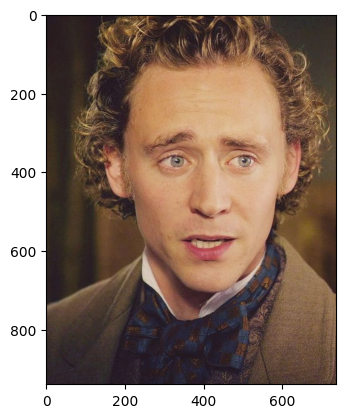

In [ ]:
res = model_detection(source='/content/drive/MyDrive/hiddl.jpg', save=True, save_txt=True)
k = plt.imread('/content/drive/MyDrive/hiddl.jpg')
plt.imshow(k)

In [ ]:
image_detect = plt.imread('/content/runs/detect/predict4/hiddl.jpg')

1/1 [==============================] - 0s 19ms/step
Tom Hiddleston


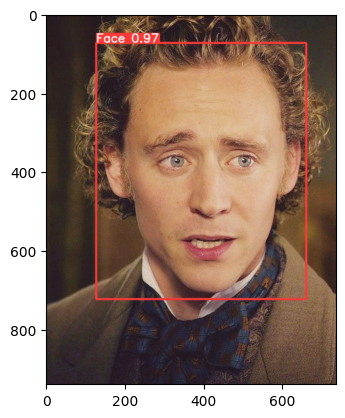

In [ ]:
image_ct = image_cut()
image_complete = photos(image_ct)
image_class = img_for_classification(image_complete)
result = model_classification.predict(image_class)

plt.imshow(image_detect)

if np.argmax(result) == 0:
  print("Tom Hiddleston")
elif np.argmax(result) == 1:
  print("Tom Holland")
else:
  print("Other")